In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 180
img_width = 180


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 955 files belonging to 3 classes.
Using 764 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Datensatz/Train",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 955 files belonging to 3 classes.
Using 191 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)


['Dosenoeffner', 'Flaschenoeffner', 'Korkenzieher']


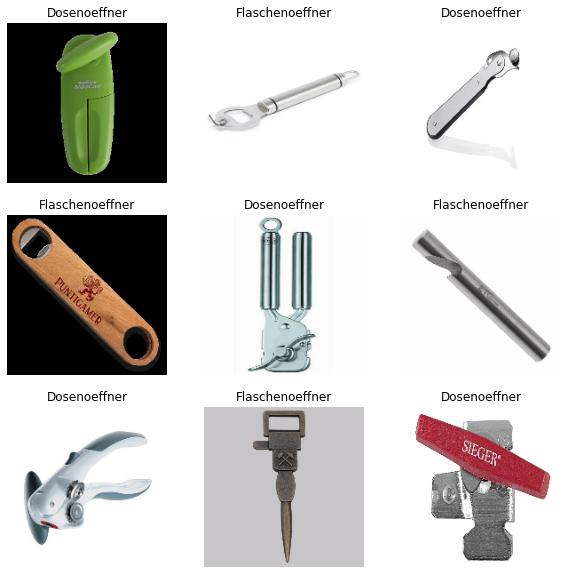

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
normalization_layer = layers.Rescaling(1./255)



In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.006471163 1.0


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
24/24 [==============================] - 8s 298ms/step - loss: 1.2307 - accuracy: 0.3783 - val_loss: 1.0314 - val_accuracy: 0.5026
Epoch 2/10
24/24 [==============================] - 7s 280ms/step - loss: 1.0522 - accuracy: 0.4647 - val_loss: 1.0793 - val_accuracy: 0.3613
Epoch 3/10
24/24 [==============================] - 7s 274ms/step - loss: 0.9966 - accuracy: 0.5000 - val_loss: 0.9160 - val_accuracy: 0.5550
Epoch 4/10
24/24 [==============================] - 7s 279ms/step - loss: 0.8423 - accuracy: 0.6073 - val_loss: 0.8340 - val_accuracy: 0.6230
Epoch 5/10
24/24 [==============================] - 7s 276ms/step - loss: 0.7002 - accuracy: 0.7107 - val_loss: 0.8718 - val_accuracy: 0.6230
Epoch 6/10
24/24 [==============================] - 7s 280ms/step - loss: 0.5250 - accuracy: 0.7893 - val_loss: 0.9312 - val_accuracy: 0.6702
Epoch 7/10
24/24 [==============================] - 7s 281ms/step - loss: 0.3238 - accuracy: 0.8874 - val_loss: 1.0320 - val_accuracy: 0.7330
Epoch 

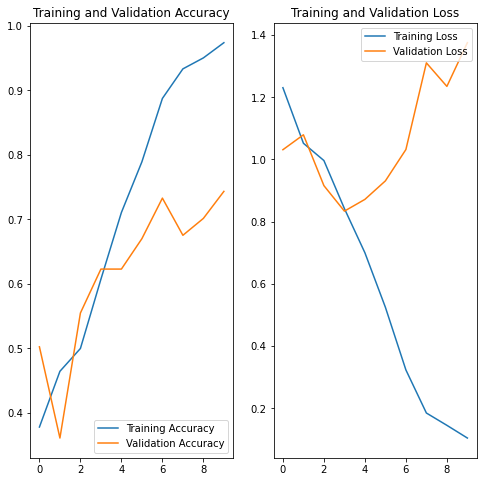

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
